
# Theme Classifier


In [1]:
# Install necessary packages
!pip install transformers tqdm pyvis datasets

import pandas as pd
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import os
import torch
import glob2
import json
from nltk import sent_tokenize
from multiprocessing import Pool, cpu_count, Manager, set_start_method
import nltk
from datasets import Dataset, load_from_disk, DatasetDict

# Download NLTK data
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does no

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#loading hugging face 0 shot classifier pipeline with BART model
device = 0 if torch.cuda.is_available() else -1

theme_classifier = pipeline("zero-shot-classification",
                            model='facebook/bart-large-mnli',
                            device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
import os
import json
import pandas as pd
from tqdm import tqdm
import torch
from transformers import pipeline
from datasets import Dataset, load_from_disk
from nltk.tokenize import sent_tokenize
import glob2

# File paths
subtitles_dir = "/content/drive/MyDrive/Colab Notebooks/2024 Data Science Projects/Naruto/Subtitles/*.ass"
characters_file_path = '/content/drive/MyDrive/Colab Notebooks/2024 Data Science Projects/Naruto/characters.json'
intermediate_data_path = '/content/drive/MyDrive/Colab Notebooks/2024 Data Science Projects/Naruto/intermediate_data'
final_output_path = '/content/drive/MyDrive/Colab Notebooks/2024 Data Science Projects/Naruto/final_results_theme_classifier.json'

# Ensure the intermediate directory exists
os.makedirs(intermediate_data_path, exist_ok=True)

# Check if intermediate data exists
if os.path.exists(f"{intermediate_data_path}/subtitles_dataset_theme_classifier"):
    print("Loading existing subtitles dataset...")
    dataset = load_from_disk(f"{intermediate_data_path}/subtitles_dataset_theme_classifier")
else:
    # Extracting subtitles & characters from the saved files
    subtitles_paths = sorted(glob2.glob(subtitles_dir))

    with open(characters_file_path, 'r') as file:
        character_names = [item['character'] for item in json.load(file)]

    # Reading the file data
    def read_subtitle_file(path):
        with open(path, 'r', encoding='utf-8') as file:
            lines = file.readlines()[15:]  # Skip the first 15 lines
            rows = [line.split(',')[9].replace("\\N", ' ').replace("{\i1}", ' ').replace("{\i0}", ' ') for line in lines if len(line.split(',')) > 9]
            script = " ".join(rows)
        filename = path.split('/')[-1]
        episode = int(filename.split('-')[1].split()[0].strip())
        return {"episode": episode, "script": script}

    # Reading files and creating a dataset
    results = [read_subtitle_file(path) for path in tqdm(subtitles_paths, desc="Reading Subtitles")]
    dataset = Dataset.from_dict(pd.DataFrame(results))

    # Save the intermediate dataset with theme classifier in the filename
    dataset.save_to_disk(f"{intermediate_data_path}/subtitles_dataset_theme_classifier")

# Loading hugging face zero-shot classifier pipeline with BART model
device = 0 if torch.cuda.is_available() else -1
theme_classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', device=device)

# Check if the final output exists
if os.path.exists(final_output_path):
    print("Loading existing final results...")
    with open(final_output_path, 'r') as f:
        final_results = json.load(f)
    # Convert the final results into a DataFrame
    df = pd.DataFrame(final_results)
    # Flatten the 'emotions' dictionary into columns
    emotion_df = df.join(pd.json_normalize(df['emotions']))
    emotion_df = emotion_df.drop(columns=['emotions','episode'])

else:
    # Function to get themes from a batch of scripts
    def get_themes_batch(batch):
        script_batches = [" ".join(sent_tokenize(script)) for script in batch['script']]

        candidate_labels = ['friendship', 'hope', 'sacrifice', 'battle', 'self development', 'betrayal', 'love', 'dialogue', 'revenge']

        emotion_output = theme_classifier(script_batches, candidate_labels, multi_label=True)

        # Process outputs
        batch_emotions = []
        for output in emotion_output:
            emotions = {label: score for label, score in zip(output['labels'], output['scores'])}
            batch_emotions.append(emotions)
        return {"emotions": batch_emotions}

    # Processing themes using the dataset.map for parallel processing
    results = dataset.map(get_themes_batch, batched=True, batch_size=16)

    # Convert the results to a DataFrame
    df_results = pd.DataFrame(results)

    # Save the final results with theme classifier in the filename
    final_results = df_results[['episode', 'emotions']].to_dict(orient='records')
    with open(final_output_path, 'w') as f:
        json.dump(final_results, f, indent=4)

    # Flatten the 'emotions' dictionary into columns
    emotion_df = df_results.join(pd.json_normalize(df_results['emotions']))
    emotion_df = emotion_df.drop(columns=['emotions','episode'])


# Output the final results
print(emotion_df)


Loading existing subtitles dataset...
Loading existing final results...
       battle  betrayal  dialogue  friendship      hope      love   revenge  \
0    0.945080  0.903118  0.937338    0.966753  0.972636  0.912585  0.981144   
1    0.267104  0.068209  0.271337    0.037291  0.295526  0.054404  0.263659   
2    0.780805  0.618127  0.768369    0.625108  0.782495  0.662244  0.741533   
3    0.956352  0.871163  0.931718    0.837118  0.948477  0.904356  0.933397   
4    0.972856  0.874188  0.972744    0.867963  0.972820  0.921540  0.970120   
..        ...       ...       ...         ...       ...       ...       ...   
493  0.781078  0.760438  0.861807    0.739665  0.803411  0.670351  0.835279   
494  0.899471  0.833939  0.913503    0.782978  0.864990  0.816553  0.893918   
495  0.522053  0.545786  0.549880    0.149597  0.696893  0.182750  0.612702   
496  0.956801  0.945920  0.962768    0.958019  0.964648  0.958029  0.955758   
497  0.660009  0.658377  0.626297    0.540077  0.783788  0.

In [17]:
# Display the first few rows of the transformed DataFrame
emotion_df.head()

,battle,betrayal,dialogue,friendship,hope,love,revenge,sacrifice,self development
0,0.945080,0.903118,0.937338,0.966753,0.972636,0.912585,0.981144,0.968844,0.988826
1,0.267104,0.068209,0.271337,0.037291,0.295526,0.054404,0.263659,0.170085,0.282310
2,0.780805,0.618127,0.768369,0.625108,0.782495,0.662244,0.741533,0.769943,0.804353
3,0.956352,0.871163,0.931718,0.837118,0.948477,0.904356,0.933397,0.916968,0.962748
4,0.972856,0.874188,0.972744,0.867963,0.972820,0.921540,0.970120,0.979692,0.989139


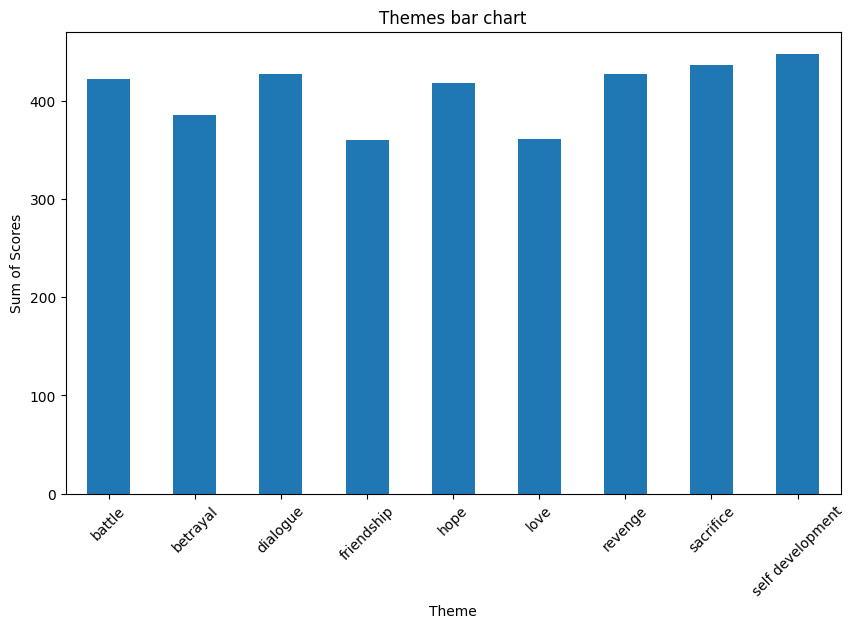

In [18]:
import matplotlib.pyplot as plt

# Sum each column (emotion) in the DataFrame
emotion_sums = emotion_df.sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
emotion_sums.plot(kind='bar')
plt.title('Themes bar chart')
plt.xlabel('Theme')
plt.ylabel('Sum of Scores')
plt.xticks(rotation=45)
plt.show()

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install --upgrade pandas
!pip install evaluate
!pip install accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import pandas as pd
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch import nn


In [ ]:
#Define parameters for hugging face model
data_path = "/content/drive/MyDrive/Colab Notebooks/2024 Data Science Projects/Naruto/jutsus.jsonl" #@param {type:"string"}
text_column_name = "text" #@param {type:"string"}
label_column_name = "jutsu" #@param {type:"string"}

model_name = "distilbert-base-uncased" #@param {type:"string"}
test_size = 0.2 #@param {type:"number"}
num_labels = 3 #@param {type:"number"}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#read and prepare dataset
df_jus = pd.read_json(data_path, lines=True)
df_jus.head()

,jutsu_name,jutsu_type,jutsu_description
0,10 Hit Combo,Taijutsu,Lars punches the opponent before striking them...
1,Air Sand Protective Wall,Ninjutsu,This air defence technique creates a giant shi...
2,All-Killing Ash Bones,"Kekkei Mōra, Ninjutsu","A certain-kill technique, the user hardens the..."
3,Air Raid Shot,Ninjutsu,"Kankurō's puppet, Karasu, soars into the air w..."
4,All is Suffering,"Kekkei Genkai, Ninjutsu","Using the giant statue as a medium, each of th..."


In [ ]:
unique_jutsus = df_jus['jutsu_type'].str.split(',').explode().str.strip().unique()
print(unique_jutsus)

unique_jutsus = df_jus['jutsu_type'].str.split(',').explode().str.strip().value_counts()
print(unique_jutsus)

['Taijutsu' 'Ninjutsu' 'Kekkei Mōra' 'Kekkei Genkai' 'Hiden' 'Genjutsu'
 'Cooperation Ninjutsu' 'Kinjutsu' 'Shurikenjutsu' 'Clone Techniques'
 'Fūinjutsu' 'Kenjutsu' 'Chakra Flow' 'Dōjutsu' 'Fighting Style'
 'Bukijutsu' 'Senjutsu' 'Collaboration Techniques' 'Medical Ninjutsu'
 'Regeneration Techniques' 'General skill' 'Juinjutsu' ''
 'Barrier Ninjutsu' 'Chakra Absorption Techniques'
 'Scientific Ninja Tool Techniques' 'Shinjutsu' 'Space–Time Ninjutsu'
 'Reincarnation Ninjutsu' 'Nintaijutsu' 'Jujutsu' 'Kyūjutsu'
 'Fighting style' 'Space-Time Ninjutsu' 'Kekkei Tōta' 'Ninshū']
jutsu_type
Ninjutsu                            2222
Taijutsu                             629
Kekkei Genkai                        550
Hiden                                303
Dōjutsu                              215
Cooperation Ninjutsu                 202
Kenjutsu                             177
Space–Time Ninjutsu                  147
Fūinjutsu                            130
Bukijutsu                            12

In [ ]:
#using 3 main categories of Jutsu to simplify model
def simplify_jutsu(jutsu):
    if 'Genjutsu' in jutsu:
        return 'Genjutsu'
    if 'Taijutsu' in jutsu:
        return 'Taijutsu'
    if 'Ninjutsu' in jutsu:
        return 'Ninjutsu'

    return None

In [ ]:
#applying function
df_jus['simple_jutsu'] = df_jus['jutsu_type'].apply(simplify_jutsu)

#creating new column and refining df
df_jus['text'] = df_jus['jutsu_name']+'. '+df_jus['jutsu_description']
df_jus['jutsu'] = df_jus['simple_jutsu']
df_jus= df_jus[['text','jutsu']]
df_jus = df_jus.dropna()
df_jus.head()

,text,jutsu
0,10 Hit Combo. Lars punches the opponent before...,Taijutsu
1,Air Sand Protective Wall. This air defence tec...,Ninjutsu
2,All-Killing Ash Bones. A certain-kill techniqu...,Ninjutsu
3,"Air Raid Shot. Kankurō's puppet, Karasu, soars...",Ninjutsu
4,All is Suffering. Using the giant statue as a ...,Ninjutsu


In [ ]:
#Encoding the jutsu to be input into model
le = preprocessing.LabelEncoder()
le.fit(df_jus[label_column_name].tolist())
df_jus['label'] = le.transform(df_jus[label_column_name].tolist())
df_jus.head()

,text,jutsu,label
0,10 Hit Combo. Lars punches the opponent before...,Taijutsu,2
1,Air Sand Protective Wall. This air defence tec...,Ninjutsu,1
2,All-Killing Ash Bones. A certain-kill techniqu...,Ninjutsu,1
3,"Air Raid Shot. Kankurō's puppet, Karasu, soars...",Ninjutsu,1
4,All is Suffering. Using the giant statue as a ...,Ninjutsu,1


In [ ]:
#Dataset is imbalanced between Jutsu types we need to use class weights to ensure accurate model training
class_weights = compute_class_weight('balanced',
                     classes=sorted(df_jus['label'].unique().tolist()),
                     y=df_jus['label'].tolist()).tolist()

In [ ]:
#train test (stratify to ensure even split of data) and convert to huggingface dataset
df_train,df_test = train_test_split(df_jus,test_size=test_size,stratify=df_jus['label'])

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2174 [00:00<?, ? examples/s]

Map:   0%|          | 0/544 [00:00<?, ? examples/s]

In [ ]:
#initialise the model and set up training arguments
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#huggingface trainer model
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device=device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch")

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#train and save the model
trainer.train()
trainer.save_model('jutsu_model')


Epoch,Training Loss,Validation Loss,Accuracy
1,0.999600,1.027976,0.851103
2,0.895100,0.858464,0.863971
3,0.895900,0.908748,0.884191
4,0.853700,1.013869,0.891544
5,0.838300,0.970221,0.900735


In [ ]:
#Evaluate the model
preds = trainer.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.92      0.97      0.94      1599
           2       0.90      0.87      0.89       497

    accuracy                           0.91      2174
   macro avg       0.61      0.61      0.61      2174
weighted avg       0.88      0.91      0.90      2174



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
preds = trainer.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.91      0.96      0.94       400
           2       0.86      0.83      0.85       125

    accuracy                           0.90       544
   macro avg       0.59      0.60      0.59       544
weighted avg       0.87      0.90      0.88       544



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
